# Augmentation / Ponderação
- Baseia-se em um modelo que calcula a probabilidade de aprovação dos proponentes (Modelo AR - target aprovado/rejeitado).
- A partir dele são criadas classes de risco (AR) - usualmente decis - para calcular os pesos a serem aplicados nos aprovados (ponderação).
- O peso representa o inverso da propoção de aceitos em determinada faixa (A1 + R1 / A1).
- O objetivo final é que os proponentes aceitos em determinada faixa sejam ponderados para representar tanto aprovados, quanto rejeitados.
- Por fim modelamos apenas com os aceitos, utilizando os pesos obtidos com o modelo AR (e faixas de risco).
- A lógica é a suposição que indivíduos com valores próximos do escore AR são similares, independentemete de terem sido aprovados ou recusados. Assim, para uma dada classe, clientes aprovados são ponderados de forma a representar tanto aprovados, quanto recusados dessa classe.
- Perceba que quanto menos aprovados em uma classe, maior será o peso dado a um cliente aceito dessa faixa.

In [1]:
import sys
sys.path.append('C:\\git\\reject-inference-toy-examples\\')
from reject_inference.utils.helpers import CreditMetrics
from reject_inference.main import RejectInference

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns

In [2]:
df = pd.read_csv("../data/credit_data.csv").dropna().drop_duplicates()

## Modelagem AR (Aprovados/Rejeitados)
- Aqui precisaremos definir uma (suposta) taxa de aprovação para dividir o dataset entre aprovados e reprovados.

In [3]:
taxa_aprovacao = 0.65

In [4]:
# Step 0: Dividir amostra entre aprovados e rejeitados para a simulação
X_aprovados, X_rejeitados, y_aprovados, y_rejeitados = train_test_split(
    df.drop(columns=['default', 'clientid']), df['default'], test_size=(1-taxa_aprovacao), random_state=42, stratify=df['default']
)

In [5]:
# Step 0.1: Criar target do modelo AR:
X_aprovados['aprovacao'] = 1
X_rejeitados['aprovacao'] = 0

# Une dados de aprovados e rejeitados
df_AR = pd.concat([X_aprovados, X_rejeitados])

In [6]:
# Step 1: Criar o modelo AR cujo o output será a probabilidade de aprovação 
# de determinada proposta
AR_model = LogisticRegression()
AR_model.fit(df_AR.drop(columns='aprovacao'), df_AR['aprovacao'])

LogisticRegression()

## Augmentation

In [7]:
# Step 2: Cria coluna com a probabilidade de aprovação do modelo AR
df_AR['prob_ap'] = AR_model.predict_proba(df_AR.drop(columns='aprovacao'))[:, 1]

In [8]:
# Step 3: Gera dataset de aprovados 'aumentados' com seus respectivos pesos
aug = RejectInference(data = df_AR, prob_column='prob_ap')

augmented_df = aug.augmentation(flag_aprovado_column='aprovacao')

## Modelagem com aprovados aumentados (ponderados)

In [9]:
# Une os dados
df_final = pd.concat([augmented_df.reset_index(drop=True), y_aprovados.reset_index(drop=True)], axis=1)

In [10]:
# Step 4: Modelar aprovados ponderados
# Step 4.1: Divisão treino/teste
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    df_final[['income', 'age', 'loan']],
    df_final['default'],
    augmented_df['weight'],
    test_size=0.2, random_state=42
)

In [11]:
scorecard_B = LogisticRegression()
scorecard_B.fit(X_train, y_train)

LogisticRegression()

## Resultados do Modelo

In [12]:
y_pred = scorecard_B.predict(X_test)

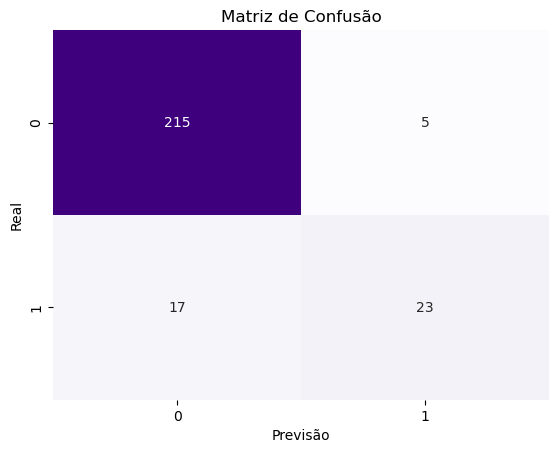

In [13]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       220
           1       0.82      0.57      0.68        40

    accuracy                           0.92       260
   macro avg       0.87      0.78      0.81       260
weighted avg       0.91      0.92      0.91       260



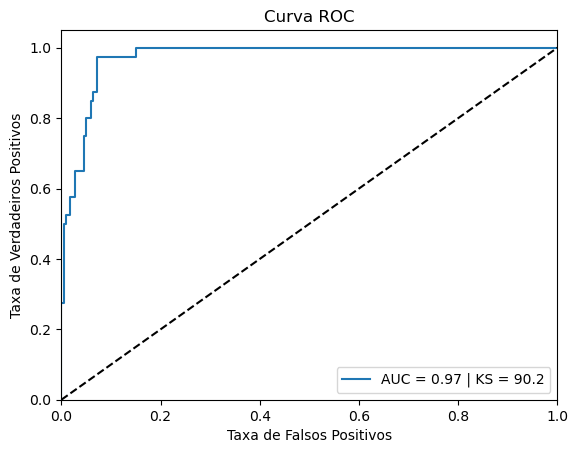

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, scorecard_B.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, scorecard_B.predict_proba(X_test)[:, 1])
ks = np.max(np.abs(tpr - fpr))

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f} | KS = {100*ks:.1f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

plt.show()

### Métricas de crédito para comparação das técnicas

In [16]:
metricas = CreditMetrics(data = df_final,
                         target_column = 'default')

metricas.generate_report(y_train, 
                        scorecard_B.predict(X_train),
                        y_test,
                        scorecard_B.predict(X_test),)

,Overall Bad Rate,Known GB Odds/Inferred GB Odds,Gini Dev,Gini Test,Overfitting (gini_dev - gini_test)
0,14.25,NA,51.78,55.23,-3.45
